In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### 패키지 설치 & 라이브러리 import

In [2]:
!pip install optuna
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [151]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [152]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [153]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [154]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [155]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(X, y):

    #Train, Test 분류
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Train, Validation 분류
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    # # 데이터 크기 출력
    # print("Train set:", X_train.shape, y_train.shape)
    # print("Validation set:", X_val.shape, y_val.shape)
    # print("Test set:", X_test.shape, y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [156]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [157]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # 시퀀스 생성
  train_x, train_y = create_sequences(tri[['lat', 'lon', 'alt']], sequence_length)

  # train, validation, test 분리
  X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(train_x, train_y)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [144]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [145]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [146]:
import math
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


In [147]:
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # input_dim에서 d_model로 변환
        self.positional_encoding = PositionalEncoding(d_model)  # 포지셔널 인코딩 추가
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=0.0 ),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(d_model, input_dim)  # d_model에서 input_dim으로 변환

    def forward(self, src):
        src = self.embedding(src)  # 입력 차원 -> d_model로 변환
        src = self.positional_encoding(src)
        src = src.permute(1, 0, 2)  # (batch_size, seq_length, d_model) -> (seq_length, batch_size, d_model)
        output = self.transformer_encoder(src)  # Transformer Encoder 통과
        output = self.fc_out(output)  # (seq_length, batch_size, d_model) -> (seq_length, batch_size, input_dim)

        # 마지막 시점의 출력만 반환
        return output[-1, :, :]  # shape: (batch_size, input_dim)


## 하이퍼파라미터 탐색

### 1. Optuna의 objective 함수 선언

- 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
- objective 함수 선언

In [148]:
import optuna

def objective(trial, tri, sequence_length):
    # 탐색할 하이퍼파라미터 값 결정
    nhead = trial.suggest_int('nhead', 2, 8)
    d_model = trial.suggest_int('d_model', nhead * 8, nhead * 64, step=nhead) # d_model을 nhead의 배수로 설정하여 짝수 보장
    if d_model % 2 != 0:     # d_model이 홀수인 경우 짝수로 조정
        d_model += 1

    if d_model % nhead != 0: # d_model이 nhead의 배수가 아닌 경우 강제로 배수로 조정
        d_model += nhead - (d_model % nhead)

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    num_epochs = 200
    intput_size = 3

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 데이터셋 로더
    train_loader, val_loader, _ = create_dataloaders(tri, batch_size, sequence_length)

    # 모델 정의: Transformer Model
    model = TransformerModel(
        input_dim=intput_size,
        seq_length=sequence_length,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward
    ).to(device)  # GPU 사용

    # 손실 함수
    criterion = nn.MSELoss()

    # 최적화 함수
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_val_loss = 0.0  # 모든 epoch에서의 validation loss의 합
    val_loss_count = 0    # 평균을 계산하기 위한 epoch 수

    # 모델 학습
    for epoch in range(num_epochs):
        # Train set으로 학습
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터도 GPU로 이동
            optimizer.zero_grad()
            output = model(batch_X)  # 출력 형태: (batch_size, input_dim)

            # Loss 계산
            loss = criterion(output, batch_y)  # y의 형태: (batch_size, input_dim)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation set에서 성능 측정
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X)

                # Loss 계산
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        # 배치 수로 나눠서 평균 validation 손실 계산
        val_loss_avg = val_loss / len(val_loader)

        # Optuna에 중간 값 보고
        trial.report(val_loss_avg, epoch)

        # 총 validation 손실 계산
        total_val_loss += val_loss_avg
        val_loss_count += 1

        # Pruning 조건 확인
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            print(f"Validation Loss at prune: {val_loss_avg:.4f}")  # Prune 시점에서 validation loss 출력

            raise optuna.TrialPruned()

    # 모든 epoch에서의 validation Loss avg 반환
    return total_val_loss / val_loss_count

### 3. 탐색 범위 외의 하이퍼파라미터 선언

In [149]:
sequence_length = 10
early_stopping_rounds = 10
n_trials = 30

### 4. 하이퍼 파라미터 탐색

In [158]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, tri, sequence_length), n_trials=n_trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-02 15:50:07,571] A new study created in memory with name: no-name-aec01439-377a-411e-aa6e-6b6d06790d32
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 15:51:36,052] Trial 0 finished with value: 0.0008487813869884449 and parameters: {'nhead': 5, 'd_model': 315, 'num_encoder_layers': 4, 'dim_feedforward': 460, 'learning_rate': 0.0008321189515088326, 'batch_size': 106}. Best is trial 0 with value: 0.0008487813869884449.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use

Trial 5 pruned at epoch 21
Validation Loss at prune: 0.0008


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 15:57:20,092] Trial 6 pruned. 


Trial 6 pruned at epoch 0
Validation Loss at prune: 0.0585


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 15:57:21,096] Trial 7 pruned. 


Trial 7 pruned at epoch 0
Validation Loss at prune: 0.0553


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 15:57:51,141] Trial 8 pruned. 


Trial 8 pruned at epoch 21
Validation Loss at prune: 0.0004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:00:28,961] Trial 9 finished with value: 0.00011839648578061317 and parameters: {'nhead': 4, 'd_model': 124, 'num_encoder_layers': 4, 'dim_feedforward': 417, 'learning_rate': 0.0005284771880690489, 'batch_size': 44}. Best is trial 9 with value: 0.00011839648578061317.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 10 pruned at epoch 0
Validation Loss at prune: 0.0478


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:01:56,290] Trial 11 finished with value: 8.77751782730808e-05 and parameters: {'nhead': 6, 'd_model': 252, 'num_encoder_layers': 2, 'dim_feedforward': 209, 'learning_rate': 0.00013927644522283015, 'batch_size': 50}. Best is trial 11 with value: 8.77751782730808e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested

Trial 12 pruned at epoch 0
Validation Loss at prune: 0.0392


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:01:57,994] Trial 13 pruned. 


Trial 13 pruned at epoch 1
Validation Loss at prune: 0.0013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:05,018] Trial 14 finished with value: 7.367223146302423e-05 and parameters: {'nhead': 4, 'd_model': 80, 'num_encoder_layers': 3, 'dim_feedforward': 437, 'learning_rate': 0.0003203094035690874, 'batch_size': 44}. Best is trial 14 with value: 7.367223146302423e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested

Trial 15 pruned at epoch 0
Validation Loss at prune: 0.0682


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:07,268] Trial 16 pruned. 


Trial 16 pruned at epoch 2
Validation Loss at prune: 0.0006


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:08,013] Trial 17 pruned. 


Trial 17 pruned at epoch 0
Validation Loss at prune: 0.0783


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:10,980] Trial 18 pruned. 


Trial 18 pruned at epoch 2
Validation Loss at prune: 0.0004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:12,907] Trial 19 pruned. 


Trial 19 pruned at epoch 0
Validation Loss at prune: 0.1018


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:13,957] Trial 20 pruned. 


Trial 20 pruned at epoch 0
Validation Loss at prune: 0.0069


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:15,717] Trial 21 pruned. 


Trial 21 pruned at epoch 1
Validation Loss at prune: 0.0009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:17,456] Trial 22 pruned. 


Trial 22 pruned at epoch 1
Validation Loss at prune: 0.0012


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:22,472] Trial 23 pruned. 


Trial 23 pruned at epoch 4
Validation Loss at prune: 0.0002


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:04:24,829] Trial 24 pruned. 


Trial 24 pruned at epoch 3
Validation Loss at prune: 0.0003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:06:01,023] Trial 25 finished with value: 0.0001224241615054779 and parameters: {'nhead': 3, 'd_model': 69, 'num_encoder_layers': 2, 'dim_feedforward': 387, 'learning_rate': 0.0005422122691168627, 'batch_size': 45}. Best is trial 14 with value: 7.367223146302423e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested

Trial 26 pruned at epoch 0
Validation Loss at prune: 0.0110


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:06:02,604] Trial 27 pruned. 


Trial 27 pruned at epoch 0
Validation Loss at prune: 0.0207


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-02 16:07:21,207] Trial 28 finished with value: 8.507042357293886e-05 and parameters: {'nhead': 4, 'd_model': 168, 'num_encoder_layers': 1, 'dim_feedforward': 430, 'learning_rate': 0.0002406565029620126, 'batch_size': 38}. Best is trial 14 with value: 7.367223146302423e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 29 pruned at epoch 0
Validation Loss at prune: 0.0049
Best hyperparameters:  {'nhead': 4, 'd_model': 80, 'num_encoder_layers': 3, 'dim_feedforward': 437, 'learning_rate': 0.0003203094035690874, 'batch_size': 44}


### 5. 하이퍼파라미터 저장

In [159]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


## 학습

### 1. 하이퍼파라미터 불러오기

In [160]:
best_params = {'nhead': 7,
               'd_model': 294,
               'num_encoder_layers': 1,
               'dim_feedforward': 134,
               'learning_rate': 0.00020244245082635354,
               'batch_size': 65
               }

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 7, 'd_model': 294, 'num_encoder_layers': 1, 'dim_feedforward': 134, 'learning_rate': 0.00020244245082635354, 'batch_size': 65}


### 2. 최적의 파라미터로 모델 학습

In [161]:
sequence_length = 10
num_epochs = 150

In [162]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    seq_length=10,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [163]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수
#####################################################################
train_losses = [] # 손실 저장할 리스트
val_losses = []
#####################################################################

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 입력 데이터 차원 조정
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()
    #####################################################################
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #####################################################################

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")

#####################################################################
# Model Save
model_save_path = f"best_model_with_losses.pth"
torch.save({
    'model_state_dict': best_model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
    }, model_save_path)
print(f"Model saved: {model_save_path}")
#####################################################################


Epoch [1/150], Train Loss: 5.4464, Val Loss: 0.1393
Epoch 1/150 completed in 0.28 seconds.
Epoch [2/150], Train Loss: 0.1584, Val Loss: 0.0214
Epoch 2/150 completed in 0.33 seconds.
Epoch [3/150], Train Loss: 0.0447, Val Loss: 0.0098
Epoch 3/150 completed in 0.23 seconds.
Epoch [4/150], Train Loss: 0.0218, Val Loss: 0.0057
Epoch 4/150 completed in 0.21 seconds.
Epoch [5/150], Train Loss: 0.0140, Val Loss: 0.0038
Epoch 5/150 completed in 0.21 seconds.
Epoch [6/150], Train Loss: 0.0107, Val Loss: 0.0033
Epoch 6/150 completed in 0.22 seconds.
Epoch [7/150], Train Loss: 0.0093, Val Loss: 0.0032
Epoch 7/150 completed in 0.20 seconds.
Epoch [8/150], Train Loss: 0.0087, Val Loss: 0.0030
Epoch 8/150 completed in 0.20 seconds.
Epoch [9/150], Train Loss: 0.0078, Val Loss: 0.0024
Epoch 9/150 completed in 0.20 seconds.
Epoch [10/150], Train Loss: 0.0073, Val Loss: 0.0022
Epoch 10/150 completed in 0.22 seconds.
Epoch [11/150], Train Loss: 0.0071, Val Loss: 0.0021
Epoch 11/150 completed in 0.20 seco

### 3. 모델 요약 내용 출력

In [164]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 294]              1,176
├─PositionalEncoding: 1-2                     [1, 10, 294]              --
├─TransformerEncoder: 1-3                     [10, 1, 294]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [10, 1, 294]              427,316
├─Linear: 1-4                                 [10, 1, 3]                885
Total params: 429,377
Trainable params: 429,377
Non-trainable params: 0
Total mult-adds (M): 0.81
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.33
Estimated Total Size (MB): 0.44

## 테스트

### 1. 테스트 결과 생성

In [165]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 5.932057320023887e-05
Mean Absolute Error (MAE): 0.0061879544518888


### 2. 결과 시각화

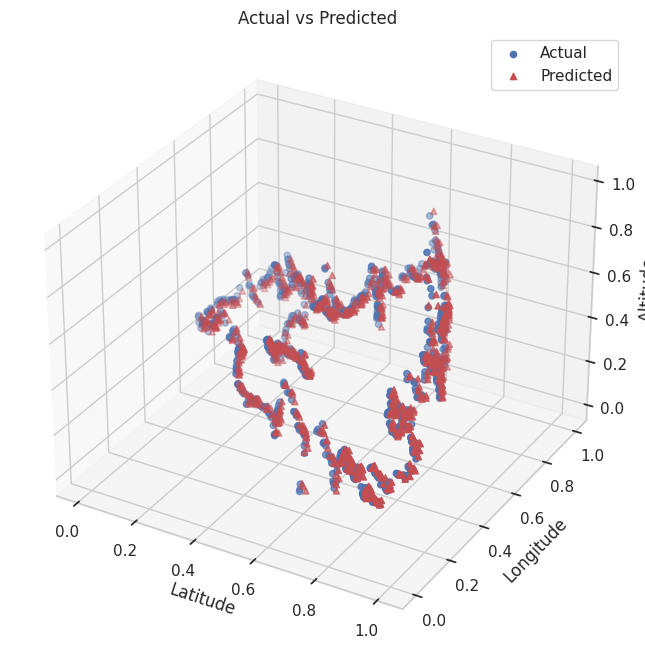

In [166]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

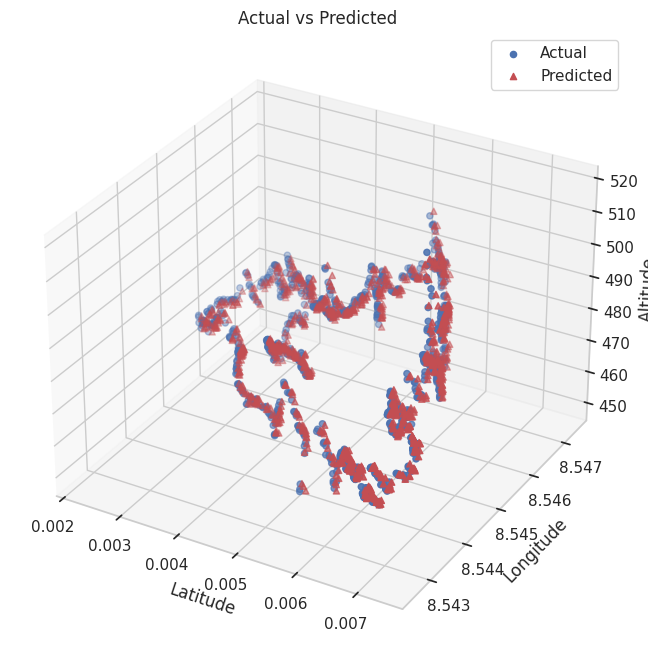

In [173]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

## Compare Models


### Model 비교 그래프

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison_v1(df, num_epochs):
    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    sns.set(style="whitegrid")

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Train Loss
    axs[0, 0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0, 0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0, 0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0, 0].set_title('Train Loss')
    axs[0, 0].set_xlabel('epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0, 0].legend()
    axs[0, 0].yaxis.grid(True, linestyle='--', alpha=0.5)  # 연한 가로줄 추가
    axs[0, 0].xaxis.grid(False)  # 세로줄 비활성화

    # Plot Valid Loss
    axs[0, 1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0, 1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0, 1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0, 1].set_title('Valid Loss')
    axs[0, 1].set_xlabel('epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[0, 1].legend()
    axs[0, 1].yaxis.grid(True, linestyle='--', alpha=0.5)  # 연한 가로줄 추가
    axs[0, 1].xaxis.grid(False)  # 세로줄 비활성화

    # Plot Train Accuracy
    axs[1, 0].plot(df['epoch'], df['train_acc_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1, 0].plot(df['epoch'], df['train_acc_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1, 0].plot(df['epoch'], df['train_acc_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1, 0].set_title('Train Accuracy')
    axs[1, 0].set_xlabel('epochs')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1, 0].legend()
    axs[1, 0].yaxis.grid(True, linestyle='--', alpha=0.5)  # 연한 가로줄 추가
    axs[1, 0].xaxis.grid(False)  # 세로줄 비활성화

    # Plot Valid Accuracy
    axs[1, 1].plot(df['epoch'], df['valid_acc_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1, 1].plot(df['epoch'], df['valid_acc_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1, 1].plot(df['epoch'], df['valid_acc_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1, 1].set_title('Valid Accuracy')
    axs[1, 1].set_xlabel('epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1, 1].legend()
    axs[1, 1].yaxis.grid(True, linestyle='--', alpha=0.5)  # 연한 가로줄 추가
    axs[1, 1].xaxis.grid(False)  # 세로줄 비활성화

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison_v2(df, num_epochs):

    # y축 limit 설정
    y_limits = [0, 0.25]

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    sns.set(style="whitegrid")

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Train Loss
    axs[0, 0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0, 0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0, 0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0, 0].set_title('Train Loss')
    axs[0, 0].set_xlabel('epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0, 0].legend()
    axs[0, 0].yaxis.grid(False)
    axs[0, 0].xaxis.grid(False)  # 세로줄 비활성화

    # Y축 수동 설정
    if y_limits:
        axs[0, 0].set_ylim(y_limits[0], y_limits[1])  # y축 범위 설정

    # Plot Valid Loss
    axs[0, 1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0, 1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0, 1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0, 1].set_title('Valid Loss')
    axs[0, 1].set_xlabel('epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[0, 1].legend()
    axs[0, 1].yaxis.grid(False)
    axs[0, 1].xaxis.grid(False)  # 세로줄 비활성화

    # Plot Train Accuracy
    axs[1, 0].plot(df['epoch'], df['train_acc_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1, 0].plot(df['epoch'], df['train_acc_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1, 0].plot(df['epoch'], df['train_acc_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1, 0].set_title('Train Accuracy')
    axs[1, 0].set_xlabel('epochs')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1, 0].legend()
    axs[1, 0].yaxis.grid(False)
    axs[1, 0].xaxis.grid(False)  # 세로줄 비활성화

    # Plot Valid Accuracy
    axs[1, 1].plot(df['epoch'], df['valid_acc_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1, 1].plot(df['epoch'], df['valid_acc_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1, 1].plot(df['epoch'], df['valid_acc_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1, 1].set_title('Valid Accuracy')
    axs[1, 1].set_xlabel('epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1, 1].legend()
    axs[1, 1].yaxis.grid(False)
    axs[1, 1].xaxis.grid(False)  # 세로줄 비활성화

    # Adjust layout
    plt.tight_layout()
    plt.show()

### 모델 불러오기

In [180]:
checkpoint = torch.load('best_model_with_losses.pth')
print(checkpoint.keys())

transformer_train_losses = checkpoint['train_losses']
transformer_val_losses = checkpoint['val_losses']

# 손실 값 확인
print(f"Train Losses: {transformer_train_losses[:5]}")
print(f"Validation Losses: {transformer_val_losses[:5]}")

dict_keys(['model_state_dict', 'train_losses', 'val_losses'])
Train Losses: [5.446429321076721, 0.15838761976920068, 0.04470263299299404, 0.021767836253275163, 0.013957710762042552]
Validation Losses: [0.139319384470582, 0.021428362117148936, 0.009818489459576085, 0.005745361442677677, 0.0038473651657113805]


<ipython-input-180-385ef1614e59>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_with_losses.pth')


### 데이터 수집

In [181]:
data = {
    'epoch': list(range(1, num_epochs + 1)),  # 실제 에포크 수만큼
    'train_loss_1': [x * 1.3 for x in train_losses],
    'train_loss_2': [x * 0.2 for x in train_losses],
    'train_loss_3': transformer_train_losses,
    'valid_loss_1': [x * 1.3 for x in val_losses],
    'valid_loss_2': [x * 0 for x in val_losses],
    'valid_loss_3': transformer_val_losses,
    'train_acc_1': [0.05, 0.1, 0.15] + [0.2] * (num_epochs - 3),
    'train_acc_2': [0.06, 0.12, 0.16] + [0.22] * (num_epochs - 3),
    'train_acc_3': [0.07, 0.13, 0.18] + [0.24] * (num_epochs - 3),
    'valid_acc_1': [0.07, 0.13, 0.16] + [0.21] * (num_epochs - 3),
    'valid_acc_2': [0.05, 0.11, 0.14] + [0.19] * (num_epochs - 3),
    'valid_acc_3': [0.08, 0.12, 0.17] + [0.23] * (num_epochs - 3),
}

### 모델 비교 그래프 그리기

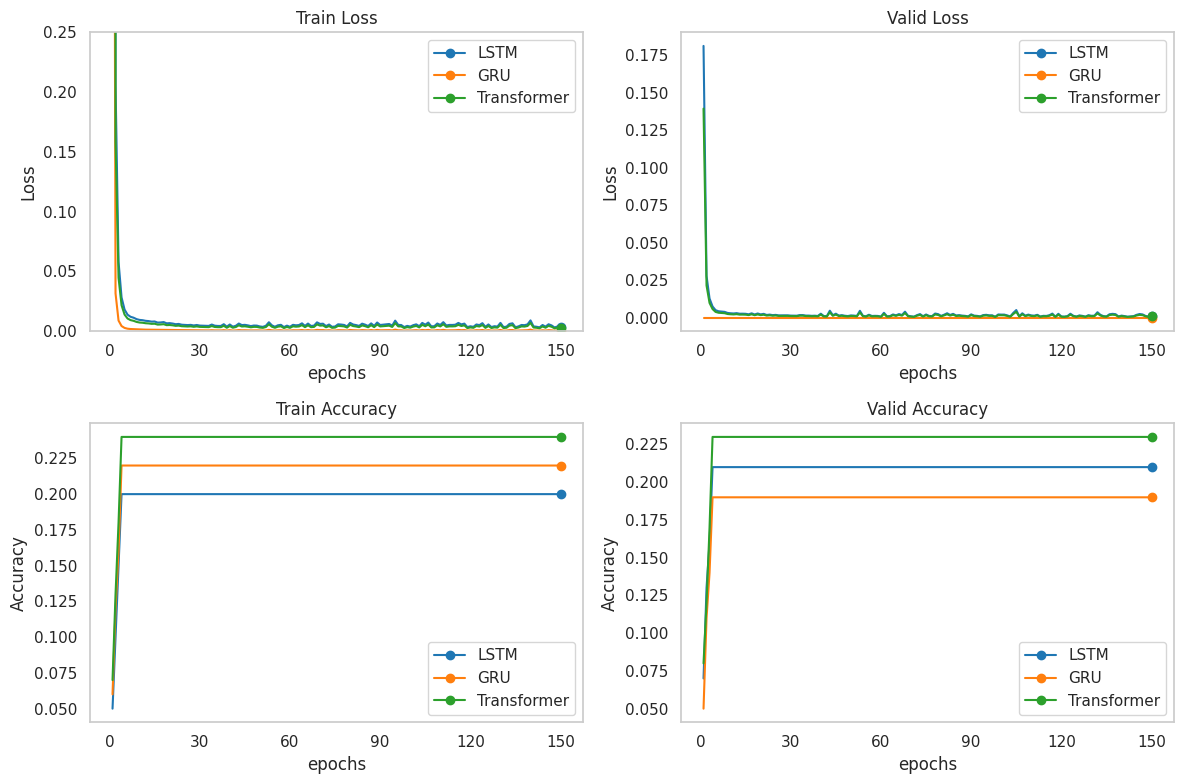

In [178]:
df = pd.DataFrame(data)

# 그래프 그리기
# plot_model_comparison_v1(df, num_epochs)
plot_model_comparison_v2(df, num_epochs)